In [ ]:
pip install Flask-API

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from flask_api import FlaskAPI

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [35]:
# We can view all of the classes that automap found
climate = base.classes.keys()
inspector = inspect(engine)
#m_cols = inspector.get_columns('measurement')
# s_cols = inspector.get_columns('station')
#for m in m_cols:
   # print(m['name'], m["type"])
# for s in s_cols:
#     print(s['name'], s["type"])
# print(base.classes.keys())

['measurement', 'station']


In [9]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

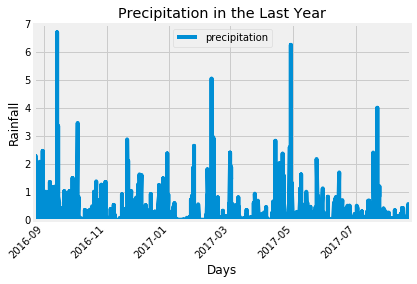

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(measurement.date).order_by(measurement.date.desc())
final_date = last_date[0][0]
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(final_date, '%Y-%m-%d') - dt.timedelta(days=366)
# # Perform a query to retrieve the data and precipitation scores
rain_query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago).all()
# # Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain_query, columns=['date', 'precipitation'])
rain_df['precipitation'] = rain_df['precipitation'].fillna(0.00) 
rain_df['date'] = pd.to_datetime(rain_df['date'], format='%Y-%m-%d')
rain_df = rain_df.set_index('date')
# Sort the dataframe by date
rain_df = rain_df.sort_values(by='date', ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(title="Precipitation in the Last Year")
plt.legend(loc='upper center')
plt.savefig("../Precipitation.png")
plt.xlabel('Days')
plt.ylabel('Rainfall')
plt.xticks(rotation='45')
plt.ylim(0,7)
plt.show()

In [34]:
temp_query = session.query(measurement.date, station.name, measurement.tobs).filter(measurement.date >= year_ago).all()
temp_df = pd.DataFrame(temp_query, columns=['date', 'station,', 'temp'])
# temp_df['date'] = pd.to_datetime(rain_df['date'], format='%Y-%m-%d')
temp_df = temp_df.set_index('date')
# Sort the dataframe by date
temp_df = temp_df.sort_values(by='date', ascending=True)
temp_df

,"station,",temp
date,,
2016-08-23,"WAIKIKI 717.2, HI US",81.0
2016-08-23,"WAIMANALO EXPERIMENTAL FARM, HI US",80.0
2016-08-23,"UPPER WAHIAWA 874.3, HI US",80.0
2016-08-23,"PEARL CITY, HI US",80.0
2016-08-23,"KUALOA RANCH HEADQUARTERS 886.9, HI US",80.0
...,...,...
2017-08-23,"WAIMANALO EXPERIMENTAL FARM, HI US",82.0
2017-08-23,"WAIHEE 837.5, HI US",82.0
2017-08-23,"HONOLULU OBSERVATORY 702.2, HI US",82.0


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

,precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


![describe](Images/describe.png)

In [22]:
# Design a query to show how many stations are available in this dataset?
nbr_of_stations = session.query(measurement.station).distinct().count()
print(f'There are {nbr_of_stations} stations in this dataset')

There are 9 stations in this dataset


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active = session.query(measurement.station, station.name, func.count(measurement.tobs)).\
filter(measurement.station == station.station).group_by(measurement.station).\
order_by(func.count(measurement.tobs).desc()).all()
# List the stations and the counts in descending order.
most_active

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [17]:
top_active = most_active[0][0]
top_active

'USC00519281'

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_active_temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs),\
func.avg(measurement.tobs)).filter(measurement.station == top_active).all()
print(f'Lowest temp: {top_active_temps[0][0]}, Highest temp: {top_active_temps[0][1]}, \
Average temp: {round(top_active_temps[0][2],1)}')

Lowest temp: 54.0, Highest temp: 85.0, Average temp: 71.7


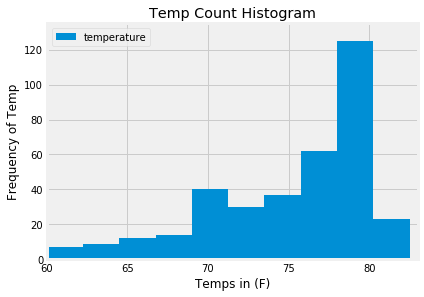

In [21]:
# Choose the station with the highest number of temperature observations.
most_temps = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.tobs).order_by(func.count(measurement.tobs).desc()).all()
top_temp_ct = most_temps[0][0]
# top_temp_ct
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.tobs).filter(measurement.date >= year_ago).\
filter(measurement.station == top_temp_ct).all()
temp_data_df = pd.DataFrame(temp_data, columns=['temperature'])

temp_data_df.plot.hist(bins=12, title="Temp Count Histogram")

plt.tight_layout()
plt.savefig("../TempCount.png")
plt.xlabel('Temps in (F)')
plt.ylabel('Frequency of Temp')
plt.xlim(60,83)
plt.ylim(0,135)
plt.show()

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [55]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacay = calc_temps('2017-03-01','2017-03-15')
vacay_df = pd.DataFrame(vacay, columns=['tmin', 'tavg', 'tmax'])
# vacay_df['tavg'] = vacay_df['tavg'].map("{:,.1f}".format)
vacay_df

,tmin,tavg,tmax
0,62.0,71.108696,82.0


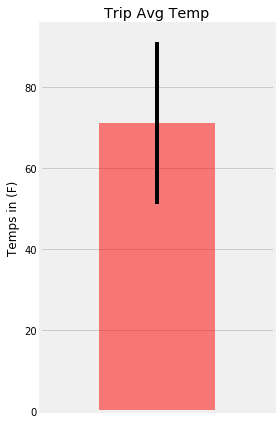

In [56]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vacay_df.plot.bar(y='tavg', yerr=(vacay_df['tmax'] - vacay_df['tmin']), title='Trip Avg Temp',\
                  color='red', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temps in (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig('../TripAvgTemp.png')
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rainfall(start_date, end_date):
    """station, name, lat, lng, elev, and precip for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
    station, name, lat, lng, elev, and precip
    """
    
    sel = [measurement.station, 
           station.name, 
           station.latitude, 
           station.longitude, 
           station.elevation, 
           measurement.prcp]
    
    return session.query(*sel).filter(measurement.station == station.station).\
    filter(measurement.date >= start_date).filter(measurement.date <= end_date).\
    group_by(measurement.station).order_by(measurement.prcp.desc()).all()

# function usage example
print(rainfall('2012-03-01', '2012-03-15'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.64), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.06), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


In [72]:
date_range = rainfall('2017-03-01', '2017-03-15')
date_range
rainfall_df = pd.DataFrame(date_range)
rainfall_df

,station,name,latitude,longitude,elevation,prcp
0,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.40
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.20
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.12
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.00
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.19
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.12
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.59


## Optional Challenge Assignment

In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [74]:
import datetime
# calculate the daily normals for your trip
normals=[]
start = datetime.datetime.strptime("03-01", "%m-%d")
end = datetime.datetime.strptime("03-15", "%m-%d")
# date_range = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
date_range = [end - datetime.timedelta(days=x) for x in range(14)]
date_range = ('03-01', '03-15', "%m-%d")
print(daily_normals(date_range))
# vac_range = 

# for date in start, end:
#     normals.append(daily_normals(date))
    
# dates = session.query(measurement.date).filter(measurement.date >= start).\
# filter(measurement.date <= finish).group_by(measurement.date).all()
# vac_range = rainfall('2012-03-01', '2012-03-15')
# normals=[]
# for date in vac_range
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

# # Use the start and end date to create a range of dates
# 
# # Stip off the year and save a list of %m-%d strings
# vac_days = [x[0] for x in dates]
# vac_days_stip = [x[5:] for x in vac_days]

# first_day = vac_days_stip[0]
# last_day = vac_days_stip[-1]
# # Loop through the list of %m-%d strings and calculate the normals for each date
# sel = [session.query(func.min(measurement.tobs),
#                 func.avg(measurement.tobs),
#                 func.max(measurement.tobs)).filter\
#                 (func.strftime("%m-%d", measurement.date) >= start).\
#                 filter(func.strftime("%m-%d", measurement.date) <= finish).\
#                 group_by(func.strftime("%m-%d", measurement.date)).all()]

# daily_normals = daily_normals[0]
# daily_normals

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 1 - probably unsupported type.
[SQL: SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE strftime(?, measurement.date) = ?]
[parameters: ('%m-%d', [datetime.datetime(1900, 3, 15, 0, 0), datetime.datetime(1900, 3, 14, 0, 0), datetime.datetime(1900, 3, 13, 0, 0), datetime.datetime(1900, 3, 12, 0, 0 ... (224 characters truncated) ... ), datetime.datetime(1900, 3, 5, 0, 0), datetime.datetime(1900, 3, 4, 0, 0), datetime.datetime(1900, 3, 3, 0, 0), datetime.datetime(1900, 3, 2, 0, 0)])]
(Background on this error at: http://sqlalche.me/e/rvf5)

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norms_df= pd.DataFrame()

# Add trip_dates to Pandas DataFrame
norms_df['date']= vac_days

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
norms_df['date'] = pd.to_datetime(norms_df['date'], format='%m-%d')

# Set index to date
norms_df.set_index('date',inplace=True)

norms_df

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
norms_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Daily Normals for Vacations")
plt.tight_layout()
plt.savefig("../DailyNormals.png")
plt.show()